In [ ]:

import pandas as pd
import os
import sys
import pathlib
import warnings
from pathlib import Path

data_path = Path('..') / 'data' / 'processed' / 'financial_data_clean.csv'
if not data_path.exists():
    raise FileNotFoundError(f"Data file not found: {data_path.resolve()}")
data = pd.read_csv(data_path.resolve(), index_col='Date', parse_dates=True)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

train_data = data['TSLA'][:'2024-12-31']
test_data = data['TSLA']['2025-01-01':]

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

Training set size: 2516
Testing set size: 259


In [5]:
# Find best parameters
arima_model_fit = auto_arima(train_data, seasonal=False, trace=True)
print(f"Best ARIMA order: {arima_model_fit.order}")

# Fit and Forecast
model_arima = ARIMA(train_data, order=arima_model_fit.order)
model_arima_res = model_arima.fit()
arima_forecast = model_arima_res.forecast(steps=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16374.056, Time=6.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16368.573, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16370.458, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16370.460, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16368.109, Time=0.80 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16372.458, Time=1.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 10.757 seconds
Best ARIMA order: (0, 1, 0)


c:\Users\weldi\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\weldi\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\weldi\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\weldi\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

In [7]:
# Scale Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train_data.values.reshape(-1,1))

# Create Sequences
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

# Prepare Test Data for LSTM
inputs = data['TSLA'][len(data) - len(test_data) - 60:].values.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test, _ = create_sequences(inputs)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

lstm_forecast = model_lstm.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)

c:\Users\weldi\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - loss: 0.0052
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - loss: 9.5402e-04
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 8.6426e-04
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 6.9969e-04
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 7.0524e-04
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 5.3553e-04
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 5.4856e-04
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 5.1329e-04
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 4.3159e-04
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 4.9845e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step


In [8]:
def calculate_metrics(actual, pred, name):
    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mape = mean_absolute_percentage_error(actual, pred)
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

metrics = [
    calculate_metrics(test_data, arima_forecast, "ARIMA"),
    calculate_metrics(test_data, lstm_forecast, "LSTM")
]
display(pd.DataFrame(metrics))

,Model,MAE,RMSE,MAPE
0,ARIMA,69.498957,82.934613,0.225579
1,LSTM,13.746302,17.737562,0.041719


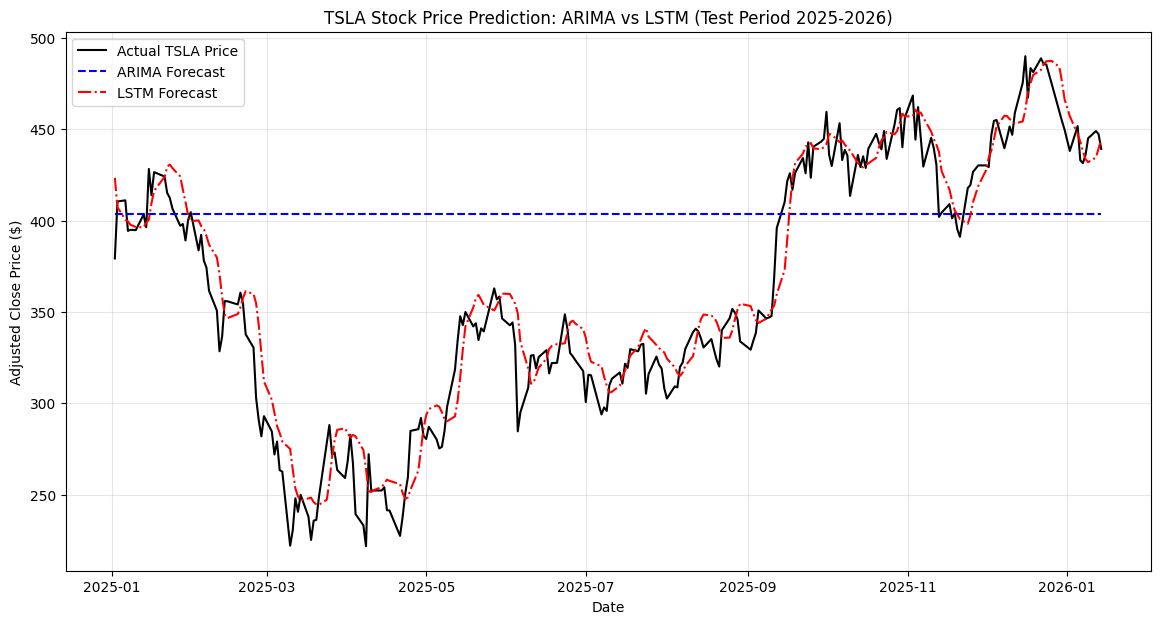

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.plot(test_data.index, test_data.values, label='Actual TSLA Price', color='black', linewidth=1.5)

plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='blue')

plt.plot(test_data.index, lstm_forecast, label='LSTM Forecast', linestyle='-.', color='red')

plt.title('TSLA Stock Price Prediction: ARIMA vs LSTM (Test Period 2025-2026)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
import joblib
from pathlib import Path
models_dir = Path('..') / 'models'
models_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(model_arima_res, str(models_dir / 'arima_model_tsla.pkl'))

['..\\models\\arima_model_tsla.pkl']